**040-mcmc**

In [1]:
import arviz as az # !new!
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

# Convergence and sample size estimation in PyMC3

We are reconstructing pymc3 parallels to Figure 7.10

In [2]:
D = [1]*35 + [0] * 15

with pm.Model() as model1:
    theta1 = pm.Beta(name="theta1", alpha=1, beta=1) # prior p.196?
    y = pm.Bernoulli(name="obs", p=theta1, observed=D) # likelihood
    

In [3]:
with model1:
    sample = pm.sample(
            draws=50000, # increase for more trustworthy results (we show small numbers to visualize the impact of the initial seed)
            # TODO Is S the Prpsl.SD? Yes
            # P.168 & 158 show that Eff.Sz.for 0.2 is mush better that 0.02.
            # but why 0.02 reult better than 0.2 here?! It depends on the choos of  
            # What is the defualt S value?
            step=pm.step_methods.metropolis.Metropolis(S=np.array([0.2])), 
#           S=np.array([0.2]) is much better than S=np.array([0.02]) p. 169
#           if did not pass, the metropolis will set it itself
            chains = 3,  # Like in Fig. 7.10 we only plot 3 chains (normallly at least 4 is recommended, which is the default)
            start = [{ "theta1": 0.01 }, { "theta1": 0.5 }, { "theta1": 0.99 }], # 3 starting points as in Fig. 7.10
#           if we let matropolis set the starting point the result is better
            discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
            tune = 500
    );
    
    
# { "theta1": 0.01 } TODO  
# The number of effective samples is smaller than 10% / 25% for some parameters.(Metropolis) 
# even when 4 chains use or draws=500000
# But with NUTS it is fine. tune = 5000 
# Is it a sign that Metropolis is not efficient!? Yes

Multiprocess sampling (3 chains in 2 jobs)
Metropolis: [theta1]
Sampling 3 chains, 0 divergences: 100%|██████████| 151500/151500 [00:28<00:00, 5325.92draws/s]
The number of effective samples is smaller than 25% for some parameters.


“The number of effective samples is smaller than 25% for some parameters.”
-- the warning we have seen in week 1 is related to ESS. Now you know what it
means.

❏ ESS should be high if you want to make inference of properties of the
posterior that depend strongly on its sparse parts (like HDI, credible itnerval)

❏
ESS > 10000 is recommended for 95% HDI inference
For strong center measures (like mean and mode in unimodal distributions) it
does not have to be high to estimate them well.

* Flip 'discard_tuned_samples' to True, to show a more representative (trustworthy) density plot (to the left)
* You should never do any real inference without discarding the tuning samples (True).  We only do this for learning purpose here.
* The prefix before convergence is called “burn-in period”, controlled by the tune parameter in pymc3 (500 is default, you may want to increase this value, if you can see that 500 is not enough time for the chains to overlap)
* Despite of what the documentation says, 'tune' apparently also works for Metropolis, not just for NUTS. Set it to zero to see how bad sampling is without burn-in


/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


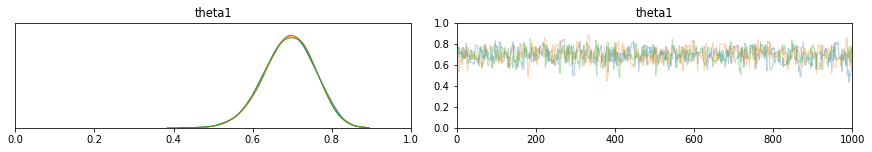

In [4]:
ax = pm.traceplot(sample)
# ax = az.plot_trace(sample)
ax[0,0].axis([0.0, 1.0, 0.0, 7.0]) # TODO Why it does not show y axis value! Since it is not what we are looking for
# Here we whant just to see if chains coverage.
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)
plt.show()
# TODO the error?! It is a warning

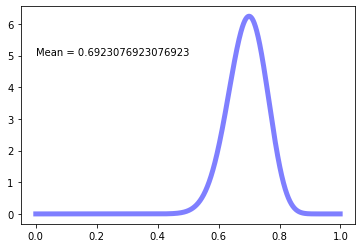

In [5]:
import scipy.stats as st

mean, var, skew, kurt = st.beta.stats(36, 16, moments='mvsk')

x = np.arange(0.000, 1, 0.001)

plt.plot(x, st.beta.pdf(x, 36, 16),'b-', lw=5, alpha=0.5, label='beta pdf')
plt.text(0, 5, f"Mean = {mean}")
plt.show()


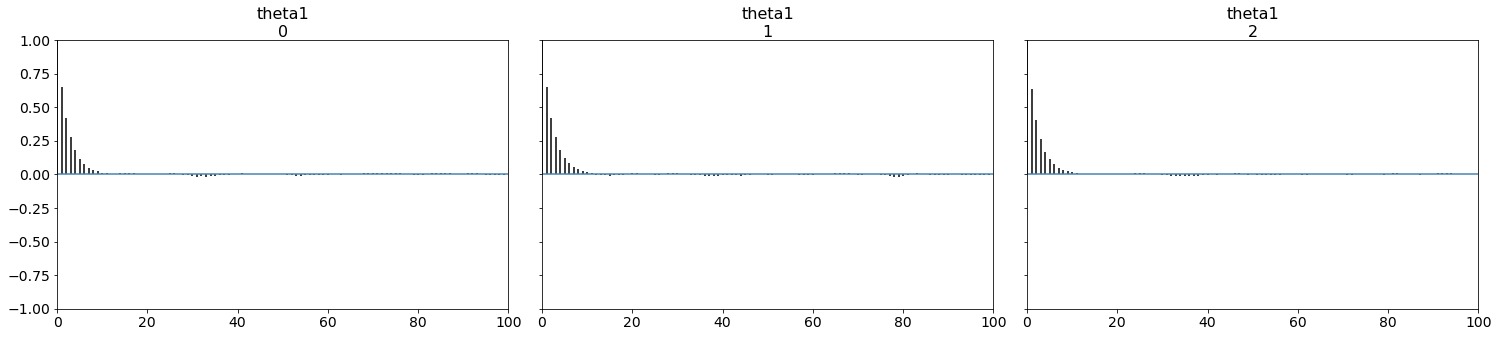

In [6]:
pm.autocorrplot(sample)
plt.show()

Autocorrelation approaches zero for all three chains (as we would like it to).

ACF(k) should be approaching zero for growing k, if the chain is random (not
clumpy). The correlation of the chain values with the chain values k
steps ahead. 

The chain are completely uncorrelated with its k values steps ahead. Since the chains are random (not
clumpy)

In [7]:
az.summary (sample)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
theta1  0.692  0.063   0.575    0.811        0.0      0.0   31935.0  31935.0   

        ess_bulk  ess_tail  r_hat  
theta1   31907.0   36703.0    1.0

I don't understand all the above stats, but mcse, ess_mean and r_hat have been discussed in the book (and slides)

<font color='green'> <font size="5">
Shrink factor / R-hat: </font> </font>

Variance within the chain vs variance between the chains

❏ This is also known as Gelman-Rubin statistics.
Has been deprecated in PyMC3 (one should use R-hat instead)

❏ R-hat convergence diagnostic is a generalization of shrink factor for more statistics, and it
should be close to 1 (like shrink factor). R-hat should be smaller than 1.05, otherwise the
burn-in period is too short, or the chains get stuck in separate regions.

❏ If R-hat / shrink-factor is too high, you get a warning from PyMC3 during sampling
(increase burn-in)


Gelman-Rubin: The degree of convergence of a random Markov Chain can be estimated using the Gelman-Rubin convergence statistic, 
^
R
, based on the stability of outcomes between and within m chains of the same length, n. Values close to one indicate convergence to the underlying distribution. Values greater than 1.1 indicate inadequate convergence.

<font color='green'> <font size="5">
Effective sample size (ESS) =</font> </font>

the actual sample size discounted by
autocorrelation:

ESS should be as close to N as possible (N is sample size). → NOTEBOOK

ESS basically tells us how much of the sample actually contains information.

<font color='green'> <font size="5">
MCSE :</font> </font> Monte Carlo Standard Error

❏ It should be decreasing for larger samples (larger ESS).

❏This is particularly useful if we want to estimate the posterior mean.

❏ It tells us how big the standard error we will have on the mean).

❏It allows to estimate the mean, even if ESS is small

<font color='red'> <font size="5">
Exercise 7.3</font> </font>

 [Purpose: Using a multimodal prior with the Metropolis
algorithm, and seeing how chains can transition across modes or get stuck
within them.] In this exercise, you will see that the Metropolis algorithm operates
with multimodal distributions.

(A) Consider a prior distribution on coin bias that puts most credibility at 0.0, 0.5,
and 1.0, which we will formulate as p(θ) = (cos(4πθ) + 1) 2 /1.5.

(B) Make a plot of the prior. Hint: theta = seq(0,1,length=501) ; plot
(theta , (cos(4*pi*theta)+1) ˆ 2/1.5 )

(C) In the script BernMetrop.R , find the function definition that specifies the prior
distribution. Inside that function definition, comment out the line that assigns a beta
density to pTheta , and instead put in a trimodal prior like this:
#pTheta = dbeta( theta , 1 , 1 )
pTheta = (cos(4*pi*theta)+1)ˆ2/1.5
To have the Metropolis algorithm explore the prior, we give it empty data. Find the
line in the script that specifies the data and set myData = c() . Run the script, using a
proposal SD=0.2. Include the graphical output in your write-up. Does the histogram of
the trajectory look like the graph of the previous part of the exercise?

(D) Repeat the previous part but now with myData = c(0,1,1) . Include the
graphical output in your write-up. Does the posterior distribution make sense? Explain
why.

(E) Repeat the previous part but now with proposal SD=0.02. Include the graphical
output in your write-up. Does the posterior distribution make sense? Explain why not;
what has gone wrong? If we did not know from the previous part that this output was
unrepresentative of the true posterior, how could we try to check? Hint: See next part.

(F) Repeat the previous part but now with the initial position at 0.99: trajec-
tory[1] = 0.99 . In conjunction with the previous part, what does this result tell us?

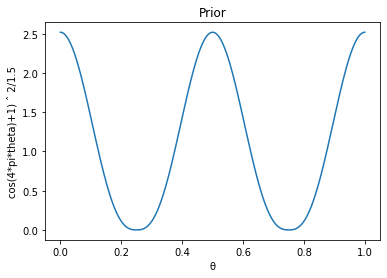

In [8]:
# (B) Make a plot of the prior. Hint: theta = seq(0,1,length=501) ; plot
# (theta , (cos(4*pi*theta)+1) ˆ 2/1.5 )

import math

theta = np.linspace (0, 1, 501)

prior = []
for t in theta:
        prior.append(((math.cos(4 * math.pi * t) ) +1) ** (2/1.5))
    
    
fig, ax = plt.subplots()
ax.set_title("Prior")   
ax.plot(theta,prior)
ax.set_xlabel('θ') 
ax.set_ylabel('cos(4*pi*theta)+1) ˆ 2/1.5') 

plt.show()


Sequential sampling (1 chains in 1 job)
Metropolis: [thetaC]
Sampling chain 0, 0 divergences: 100%|██████████| 50500/50500 [00:07<00:00, 6462.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


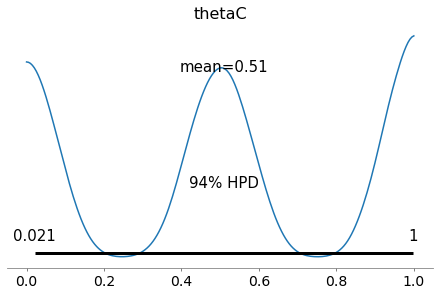

In [50]:
# C) In the script BernMetrop.R , find the function definition that specifies the prior distribution. 
# Inside that function definition, comment out the line that assigns a beta density to pTheta , and instead 
# put in a trimodal prior like this: #pTheta = dbeta( theta , 1 , 1 ) pTheta = (cos(4pitheta)+1)ˆ2/1.5 To have 
# the Metropolis algorithm explore the prior, we give it empty data. Find the line in the script that specifies 
# the data and set myData = c() . Run the script, using a proposal SD=0.2. Include the graphical output in your 
# write-up. Does the histogram of the trajectory look like the graph of the previous part of the exercise?

import theano.tensor as T
import math

def custom_prior(name='custom_prior'):
    def prior(θ):
        return (pm.math.cos(4*math.pi*θ) + 1)**2/1.5
#     we bound it since metropolis does not know the parameter space
#     interval or domain to sample within which is [0,1] here
#     almost allways it is [0,1]
#     d = (pm.math.cos(4*math.pi* 0.5) + 1)**2/1.5
#     d.eval() => array(2.66666667)
#     d = (pm.math.cos(4*math.pi* 0.2) + 1)**2/1.5
#     d.eval() => array(0.02431634)
    def bound(θ, lower=0, upper=1): # change the lower and upper to see what happen. 
#         return T.switch(T.lt(θ, lower), -np.inf, T.switch(T.gt(θ, upper), -np.inf, θ))
        return T.switch(T.lt(θ, lower), -np.inf, T.switch(T.gt(θ, upper), np.inf, θ))
#         return T.switch(T.lt(θ, lower), 0, T.switch(T.gt(θ, upper), 1, θ))

    def logp(θ):
        # Note, that this logp function kills the NUTS sampler, when initials are not set within the domain
        # Maybe see https://discourse.pymc.io/t/getting-bad-initial-energy-inf-when-trying-to-sample-simple-model/364
        return pm.math.log(prior(bound(θ)))
    return pm.DensityDist(name=name, logp=logp)

    
with pm.Model() as modelC:
    theta = custom_prior(name="thetaC")
#     pm.Bernoulli(name="obs", p=theta, observed=D ) # myData = c() then no need for Bernoulli since observed=None
    traceC = pm.sample(
        50000, 
#       Change to 0.02 to see the worse p.169 S=np.array([0.2]). Note the best S is let the metropolis chooses it
        step=pm.step_methods.metropolis.Metropolis(S=np.array([0.2])), 
        chains = 1,
        start = [{ "thetaC": 0.01 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
        tune=500
    )

pm.plot_posterior(traceC)
# az.plot_posterior(trace, kind='hist')
    
# ax = pm.traceplot(trace)
# ax = az.plot_trace(trace)
# ax[0,0].axis([0.0, 1.0, 0.0, 5.0])
# ax[0,1].axis([0,2500,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)
# pm.autocorrplot(trace)
plt.show()
# az.summary(trace)

# The histogram of the trajectory does indeed look like the trimodal prior distribution graphed in
# the previous part. Thus, the metropolis algorithm is able to sample representatively (typically) from
# multimodal distributions, at least in this case. (The HDI as marked is irrelevant and potentially
# misleading because its algorithm assumes a unimodal distribution; see Ch. 25.)

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 50500/50500 [00:08<00:00, 6045.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


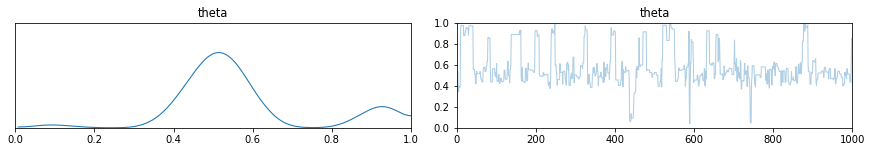

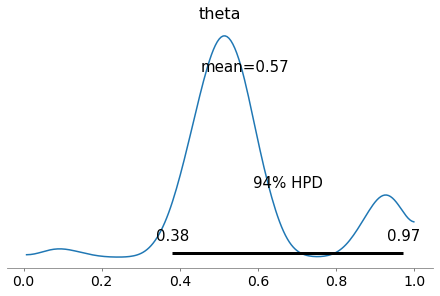

In [51]:
# (D) Repeat the previous part but now with myData = c(0,1,1) . Include the graphical output in your write-up. 
# Does the posterior distribution make sense? Explain why. Using myData=c(0,1,1) and proposal SD=0.2:

with pm.Model() as modelD:
    D = np.concatenate([np.repeat(0,1), np.repeat(1,2)])
#     D = np.array([0,1,1]) # myData = c(0,1,1) 
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    traceD = pm.sample(
                50000,
                step=pm.step_methods.metropolis.Metropolis(S=np.array([0.2])),
                chains = 1, 
                start = [{ "theta": 0.01 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
                discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
                tune = 500
           )
    
ax = pm.traceplot(traceD)
ax[0,0].axis([0.0, 1.0, 0.0, 6.0])
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)

pm.plot_posterior(traceD)
# az.plot_posterior(trace, kind='hist')
#     pm.autocorrplot(sample)
plt.show()
    
# The posterior distribution makes sense because it is a compromise between the trimodal prior
# and the gently peaked likelihood function of the small data set. The likelihood function peaks at
# 0.667 (i.e., 2/3), but is very broad, gently descending to 0 height at theta=0 and theta=1.
# Therefore the prior peaks at theta=0.5 and near theta=1.0 are “allowed” by the data, but the
# prior peak near theta=0.0 is relatively unlikely given the data. (The HDI as marked is irrelevant
# and potentially misleading because its algorithm assumes a unimodal distribution; see Ch. 25.)

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 50500/50500 [00:08<00:00, 6183.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


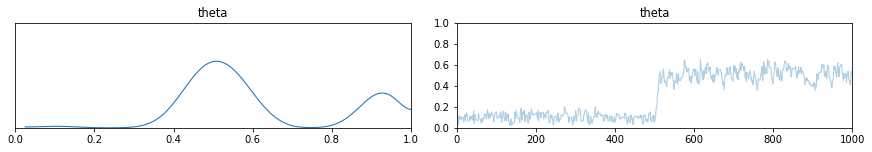

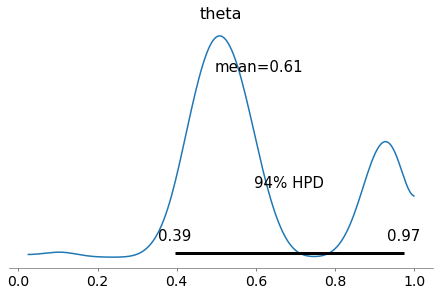

In [52]:
# (E) Repeat the previous part but now with proposal SD=0.02. Include the graphical output in your write-up. 
# Does the posterior distribution make sense? Explain why not; what has gone wrong? If we did not know from 
# the previous part that this output was unrepresentative of the true posterior, how could we try to check? 
# Hint: See next part.

with pm.Model() as modelE:
    D = np.concatenate([np.repeat(0,1), np.repeat(1,2)])
#     D = np.array([0,1,1]) # myData = c(0,1,1) 
#     D = [0,1,1]
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    traceE = pm.sample(
                50000, # even with 5000000
                step=pm.step_methods.metropolis.Metropolis(S=np.array([0.02])),
                chains = 1, 
                start = [{ "theta": 0.01 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
                discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
                tune = 500
           )
    
ax = pm.traceplot(traceE)
ax[0,0].axis([0.0, 1.0, 0.0, 6.0])
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)

pm.plot_posterior(traceE)
# az.plot_posterior(trace, kind='hist')
#     pm.autocorrplot(sample)
plt.show()

# If we did not know from other considerations that this was an anomalous result, we could start
# several chains at different starting positions and check that they all converged to the same
# region of parameter space. (See the next part of the exercise for an example of starting at a
# different point in parameter space.)

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 50500/50500 [00:08<00:00, 5697.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


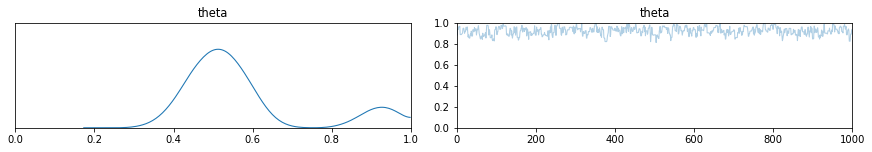

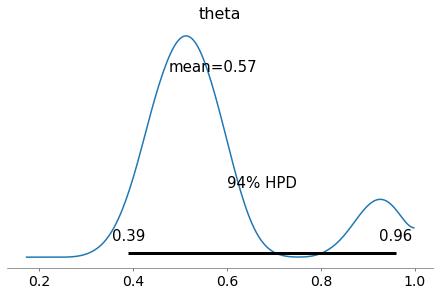

In [53]:
# (F) Repeat the previous part but now with the initial position at 0.99: trajec- tory[1] = 0.99 .
# In conjunction with the previous part, what does this result tell us?

with pm.Model() as modelF:
    D = np.concatenate([np.repeat(0,1), np.repeat(1,2)])
#     D = np.array([0,1,1]) # myData = c(0,1,1) 
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    traceF = pm.sample(
                50000,  # Specify the length of the trajectory, i.e., the number of jumps to try.
                step=pm.step_methods.metropolis.Metropolis(S=np.array([0.02])),
                chains = 1, 
                start = [{ "theta": 0.99 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
                discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
                tune = 500
           )
    
ax = pm.traceplot(traceF)
ax[0,0].axis([0.0, 1.0, 0.0, 6.0])
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)

pm.plot_posterior(traceF)
# az.plot_posterior(trace, kind='hist')
#     pm.autocorrplot(sample)
plt.show()

# If we started chains at several different values
# of theta, we would notice that they do not converge to the same region of parameter space,
# which would be a sign that the results are not fully representative of the posterior, and we
# would need to adjust the MCMC sampler.